In [1]:
!pip install "gymnasium[mujoco]"
!pip install mpi4py

In [2]:
import os
import subprocess
import torch
from matplotlib import pyplot as plt
import gymnasium as gym
import numpy as np
import pandas as pd

In [3]:
env_file = 'model_downloader.py'
env_url = "https://raw.githubusercontent.com/alibaniasad1999/master-thesis/main/Code/Python/utils/model_downloader.py"

if not os.path.isfile(env_file):
    print(f"Downloading {env_file} ...")
    subprocess.run(
        ['wget', '-q', '-O', env_file, env_url],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL
    )
    print(f"{env_file} downloaded.")
else:
    print(f"{env_file} already exists.")

from model_downloader import download_file, download_everything

trajectory = download_everything('sac, TBP, zs_sac, sac_models, zs_sac_models')

from Zero_Sum_SAC import ZS_SAC
from utils.run_utils import setup_logger_kwargs
from SAC import SAC
import TBP
from TBP import ThreeBodyEnv
import torch

model_downloader.py already exists.
trajectory.csv already exists.
Trajectory head:
   0.87018  -0.059444  0  -0.010472  -0.17514  0.1
0  0.87018  -0.059540  0  -0.010536  -0.17494    0
1  0.87017  -0.059636  0  -0.010600  -0.17474    0
2  0.87017  -0.059732  0  -0.010664  -0.17454    0
3  0.87016  -0.059828  0  -0.010728  -0.17434    0
4  0.87015  -0.059924  0  -0.010793  -0.17414    0
Data shape: (9999, 6)
TBP.py already exists.
SAC.py already exists.
Directory 'model' already exists and is not empty.
model/actor_cpu.pth already exists.
model/q1_cpu.pth already exists.
model/q2_cpu.pth already exists.
Zero_Sum_SAC.py already exists.
Directory 'model_zs' exists but is empty.
model_zs/actor_cpu.pth downloaded.
model_zs/actor_1_cpu.pth downloaded.
model_zs/q1_cpu.pth downloaded.
model_zs/q1_1_cpu.pth downloaded.
model_zs/q2_cpu.pth downloaded.
model_zs/q2_1_cpu.pth downloaded.
Directory 'utils' already exists.
Directory 'utils' already exists.
trajectory.csv already exists.


Logging data to /tmp/experiments/1747676370/progress.txt
Saving config:

{
    "ac_kwargs_class":	{
        "hidden_sizes":	[
            64,
            64
        ]
    },
    "actor_critic":	"MLPActorCritic",
    "alpha":	0.2,
    "batch_size":	1024,
    "device_class":	"cpu",
    "env_fn":	"<function <lambda> at 0x164d8fe20>",
    "epochs":	100,
    "gamma":	0.99,
    "logger_kwargs":	null,
    "lr":	0.001,
    "max_ep_len":	30000,
    "num_test_episodes":	10,
    "num_updates":	10,
    "polyak":	0.995,
    "replay_size":	1000000,
    "save_freq":	1,
    "seed":	0,
    "self":	{
        "<SAC.SAC object at 0x15d645f50>":	{
            "ac_kwargs":	{
                "hidden_sizes":	[
                    64,
                    64
                ]
            },
            "actor_critic":	"MLPActorCritic",
            "alpha":	0.2,
            "batch_size":	1024,
            "device":	"cpu",
            "env_fn":	"<function <lambda> at 0x164d8fe20>",
            "epochs":	100,
    

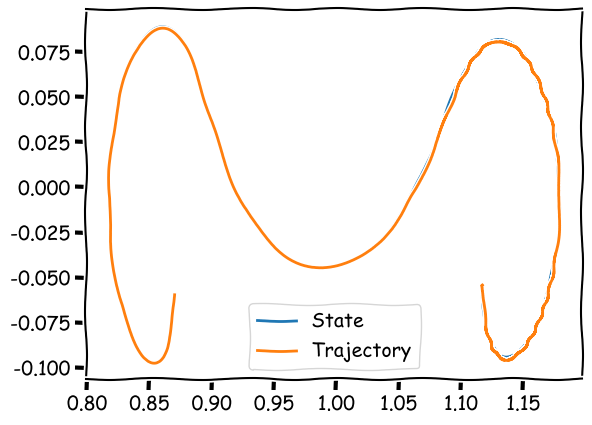

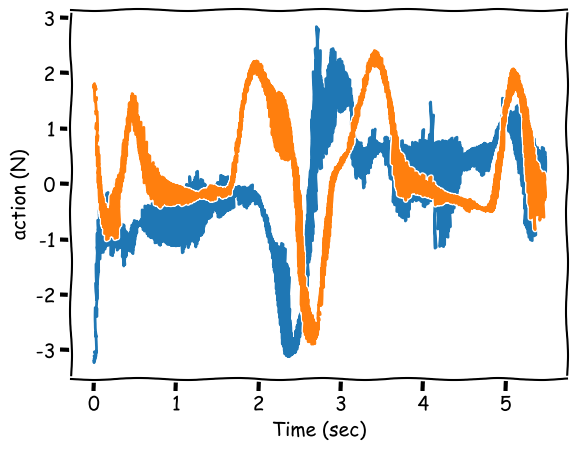

done 🥺
second player was in the game


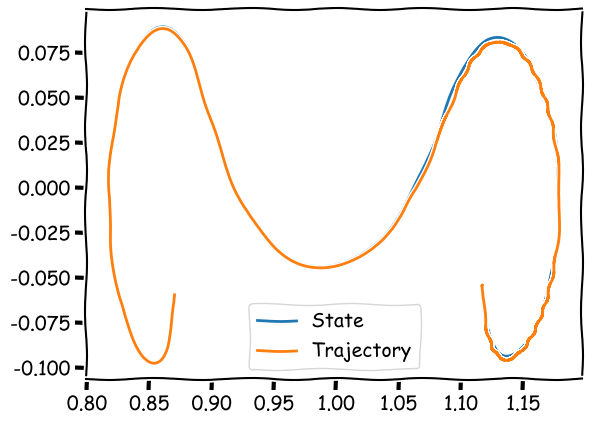

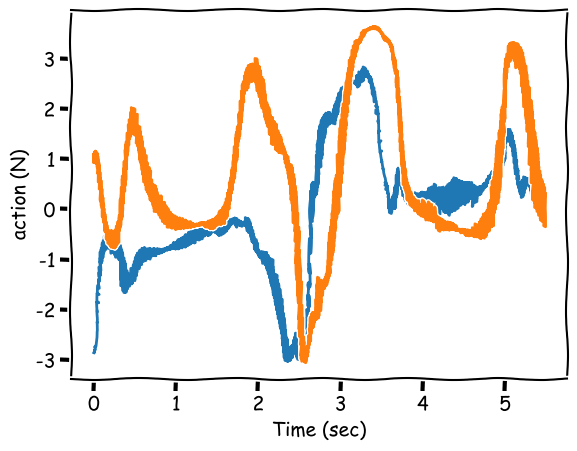

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(colorize(f"Device is {device}! 🥰😎", 'green', bold=True))
# Define variables directly
env = ThreeBodyEnv(trajectory)
hid = 64
l = 2
gamma = 0.99
seed = 0
epochs = 50
exp_name = 'sac'
steps_per_epoch_=30000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ac_kwargs = dict(hidden_sizes=[hid]*l)
states_array = []
# logger_kwargs = setup_logger_kwargs(exp_name, seed)
reward_array=[]

sac = SAC(lambda : ThreeBodyEnv(trajectory, error_range=0.01, final_range=0.001), epochs=100, device_class=device, ac_kwargs_class=ac_kwargs, steps_per_epoch=steps_per_epoch_, batch_size=1024, start_steps=5000, update_after=1000, update_every=2000)

zs_sac = ZS_SAC(lambda : ThreeBodyEnv(trajectory, error_range=0.01, final_range=0.001), epochs=100, device_class=device, ac_kwargs_class=ac_kwargs, steps_per_epoch=steps_per_epoch_, batch_size=1024, start_steps=5000, update_after=1000, update_every=2000)


zs_sac.load(filepath='model_zs/')
sac.load()


# test PPO agent (not trained)
zs_sac.test(fun_mode=True, deterministic=True, save_data=False)
sac.test(fun_mode=True, deterministic=True, save_data=False)

# zs_sac.test(fun_mode=True)
zs_sac.env.second_player = False
sac.env.second_player = False

In [9]:
class ActuatorDisturbanceWrapper(gym.Wrapper):
    """
    Gym environment wrapper that adds disturbance and extra noise to the actions taken by the agent.
    This wrapper supports the Gymnasium API where:
      - reset returns: (observation, info)
      - step returns: (observation, reward, terminated, truncated, info)
    """

    def __init__(self, env, disturbance_std=0.05, noise_std=0.02):
        super(ActuatorDisturbanceWrapper, self).__init__(env)
        self.disturbance_std = disturbance_std  # Standard deviation of actuator disturbance
        self.noise_std = noise_std  # Standard deviation of extra noise

    def reset(self, **kwargs):
        result = self.env.reset(**kwargs)
        if isinstance(result, tuple):
            obs, info = result
            return obs, info
        else:
            return result

    def step(self, action):
        # Apply actuator disturbance and extra noise to the action
        action_with_disturbance = self._apply_disturbance(action)
        action_with_noise = self._apply_noise(action_with_disturbance)

        # Execute the action in the environment with added disturbance and noise
        obs, reward, terminated, truncated, info = self.env.step(action_with_noise)
        return obs, reward, terminated, truncated, info

    def _apply_disturbance(self, action):
        """
        Applies Gaussian noise to the action to simulate actuator disturbance.
        """
        action = np.array(action)
        disturbance = np.random.normal(0, self.disturbance_std, size=action.shape)
        return np.clip(action + disturbance, self.env.action_space.low, self.env.action_space.high)

    def _apply_noise(self, action):
        """
        Applies additional random noise to the action.
        """
        noise = np.random.normal(0, self.noise_std, size=action.shape)
        return np.clip(action + noise, self.env.action_space.low, self.env.action_space.high)


def make_env_actuator_disturbance_with_noise(error_range=0.01, final_range=0.001, disturbance_std=0.05, noise_std=0.02):
    """
    Creates the ThreeBodyEnv wrapped with both actuator disturbance and extra noise.
    """
    env = ThreeBodyEnv(trajectory, error_range=error_range, final_range=final_range)
    return ActuatorDisturbanceWrapper(env, disturbance_std=disturbance_std, noise_std=noise_std)


In [10]:
def run_episode(agent, env_fn, max_steps=10000):
    """
    Run one episode using the given agent and environment function.
    Adapted for Gymnasium (reset returns (obs, info) and step returns five outputs).

    Returns:
        total_reward: Sum of rewards collected in the episode.
    """
    env = env_fn()

    obs, _ = env.reset()  # Gymnasium reset returns (obs, info)
    total_reward = 0.0
    steps = 0
    done = False
    env.second_player = False

    while not done and steps < max_steps:
        # Assume the agent provides an 'act' method to select actions
        # action = agent.get_action(obs, 0)
        action = agent.ac.act(torch.as_tensor(obs, dtype=torch.float32, device=device), deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated  # Determine if the episode is done
        total_reward += reward
        steps += 1

    env.close()
    return total_reward


def evaluate_agent(agent, env_fn, num_episodes=20, max_steps=10000):
    """
    Evaluate the agent over multiple episodes and collect cumulative rewards.

    Returns:
        returns: List of cumulative rewards from each episode.
    """
    returns = []
    for i in range(num_episodes):
        ret = run_episode(agent, env_fn, max_steps)
        returns.append(ret)
        print(f"{i} of {num_episodes}")
    return returns


[0.00919985 0.00399407 0.06145465 0.01235154]
idx 0.03983 state 0.06348089347353285
too much error 🥲😱
second player was in the game
0 of 10
[0.00762443 0.00654414 0.05690438 0.02134157]
idx 0.06524 state 0.061599745214991744
too much error 🥲😱
second player was in the game
1 of 10
[ 0.00912109  0.00412765  0.04807746 -0.00987122]
idx 0.04117 state 0.05009107037729164
too much error 🥲😱
second player was in the game
2 of 10
[ 0.00914545  0.00411781  0.04958667 -0.00642587]
idx 0.04099 state 0.05099730943135753
too much error 🥲😱
second player was in the game
3 of 10
[ 0.00830457 -0.00560265  0.02482549 -0.0161563 ]
idx 0.02837 state 0.03126797548278386
too much error 🥲😱
second player was in the game
4 of 10
[ 0.00543374  0.00839695  0.09896173 -0.03934461]
idx 0.04481 state 0.10696474622710425
too much error 🥲😱
second player was in the game
5 of 10
[ 0.00814112  0.0058093   0.05520299 -0.03417738]
idx 0.0433 state 0.06569238108916806
too much error 🥲😱
second player was in the game
6 of 10


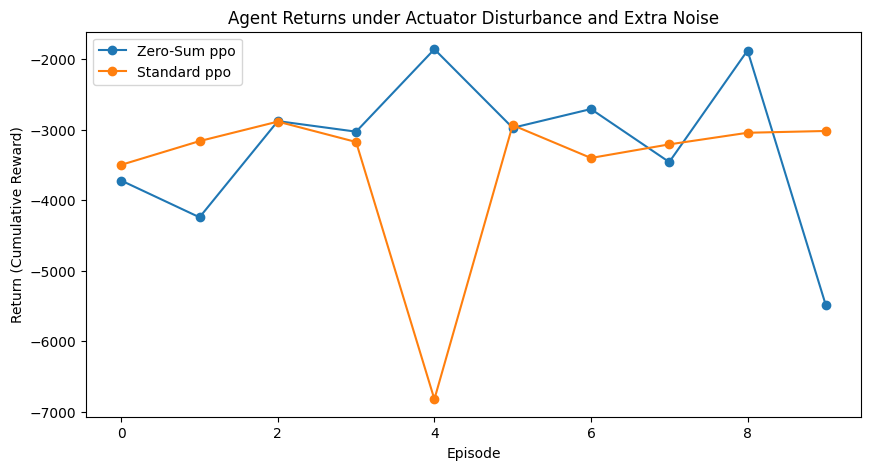

In [15]:

# Number of episodes for evaluation
num_episodes = 10

# Update the agents' environment function to use both actuator disturbance and extra noise
zs_sac.env_fn = lambda: make_env_actuator_disturbance_with_noise(disturbance_std=10, noise_std=0.1)
sac.env_fn = lambda: make_env_actuator_disturbance_with_noise(disturbance_std=10, noise_std=0.1)

# Evaluate Zero-Sum ppo and Standard ppo agents with actuator disturbance and extra noise
returns_zs_disturbance_noise = evaluate_agent(zs_sac, zs_sac.env_fn, num_episodes=num_episodes)
returns_std_disturbance_noise = evaluate_agent(sac, sac.env_fn, num_episodes=num_episodes)

# Calculate and print average returns
avg_return_zs_disturbance_noise = np.mean(returns_zs_disturbance_noise)
avg_return_std_disturbance_noise = np.mean(returns_std_disturbance_noise)

print("Zero-Sum ppo with Actuator Disturbance and Extra Noise Average Return:", avg_return_zs_disturbance_noise)
print("Standard ppo with Actuator Disturbance and Extra Noise Average Return:", avg_return_std_disturbance_noise)

# Plot the returns for visual comparison
plt.figure(figsize=(10, 5))
plt.plot(returns_zs_disturbance_noise, marker='o', label='Zero-Sum ppo')
plt.plot(returns_std_disturbance_noise, marker='o', label='Standard ppo')
plt.xlabel('Episode')
plt.ylabel('Return (Cumulative Reward)')
plt.title('Agent Returns under Actuator Disturbance and Extra Noise')
plt.legend()
plt.show()


/var/folders/cf/x6zpxdwn2dg40q0c0r418f7c0000gp/T/ipykernel_25796/3530040009.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Zero-Sum ppo', 'Standard ppo'])


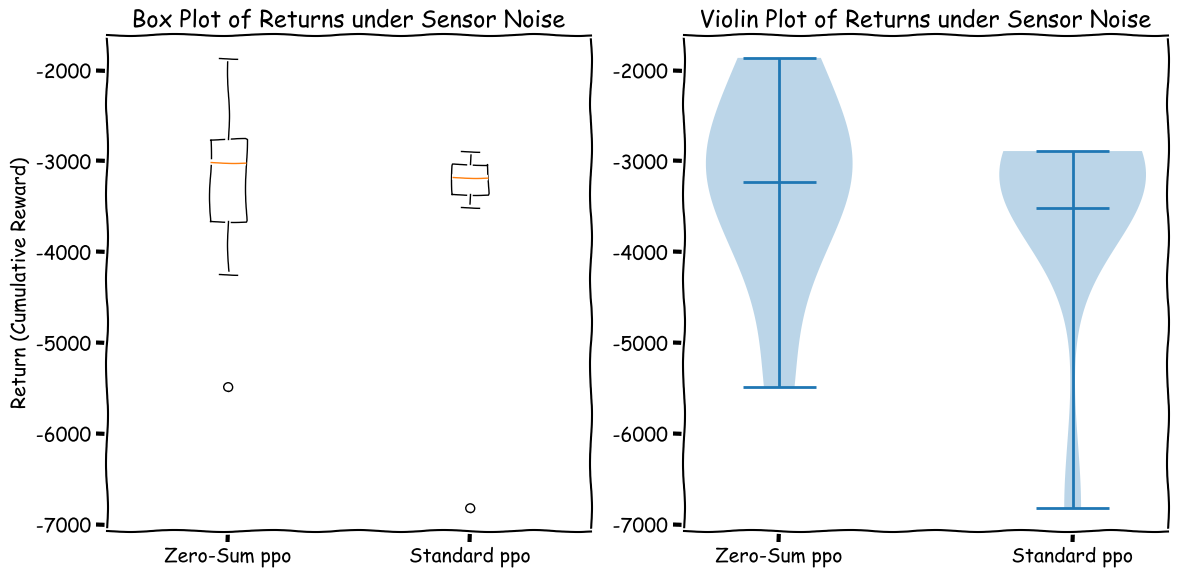

In [16]:
# Assume returns_zs and returns_std are lists of cumulative rewards from multiple episodes
data = [returns_zs_disturbance_noise, returns_std_disturbance_noise]
with plt.xkcd():
    # Create a figure with two subplots side-by-side
    plt.figure(figsize=(12, 6))

    # Box Plot
    plt.subplot(1, 2, 1)
    plt.boxplot(data, labels=['Zero-Sum ppo', 'Standard ppo'])
    plt.title('Box Plot of Returns under Sensor Noise')
    plt.ylabel('Return (Cumulative Reward)')

    # Violin Plot
    plt.subplot(1, 2, 2)
    plt.violinplot(data, showmeans=True)
    plt.xticks([1, 2], ['Zero-Sum ppo', 'Standard ppo'])
    plt.title('Violin Plot of Returns under Sensor Noise')

    plt.tight_layout()
    plt.show()


In [17]:
df  = pd.DataFrame(np.array(data).T, columns=['Zero-Sum ppo', 'Standard ppo'])
df.head()

,Zero-Sum ppo,Standard ppo
0,-3721.660135,-3498.396476
1,-4242.583901,-3162.071263
2,-2878.556266,-2885.577570
3,-3028.269530,-3174.825816
4,-1859.304772,-6822.030953


In [18]:
# save csv
df.to_csv('evaluation_returns.csv', index=False)